# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

#### By Sam McCormick

### Exploratory analysis

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,305
unique,2
top,warning
freq,304


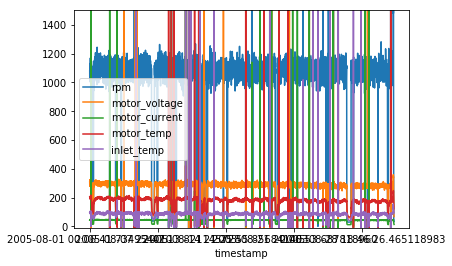

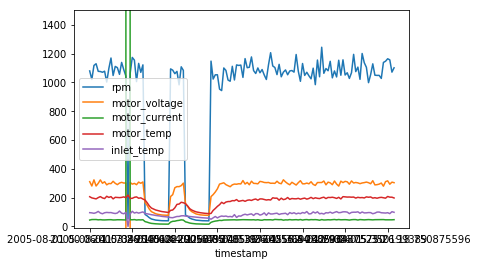

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp")

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

In [2]:
print(rms.shape)
print(rms.head())
rms.tail()

(91715, 5)
                                    rpm  motor_voltage  motor_current  \
timestamp                                                               
2003-12-13 19:56:43.777979848  0.150438      -0.059544       0.045503   
2003-12-13 20:07:32.457298714  0.511660       0.627101       0.208669   
2003-12-13 20:13:43.182783330  0.824233       1.732618       0.286401   
2003-12-13 20:27:19.295198297  1.506626       3.115258       0.483992   
2003-12-13 20:35:08.719032171  2.034869       3.923323       0.851620   

                               motor_temp  inlet_temp  
timestamp                                              
2003-12-13 19:56:43.777979848    5.084823    0.019528  
2003-12-13 20:07:32.457298714    7.334172    2.081454  
2003-12-13 20:13:43.182783330    8.843053    3.485346  
2003-12-13 20:27:19.295198297   11.749493    6.041188  
2003-12-13 20:35:08.719032171   12.947061    7.309662  


,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,
2005-09-10 16:53:09.928274306,1062.943307,250.265873,36.920420,145.112814,71.801519
2005-09-10 17:05:07.887020827,1062.091452,266.874020,36.278345,139.632508,64.635512
2005-09-10 17:16:44.847084444,991.301318,264.708451,39.463490,147.000205,71.218320
2005-09-10 17:24:30.871246498,1126.293582,264.660856,38.824472,148.408298,70.050136
2005-09-10 17:36:47.236452969,1066.459970,252.919940,36.583988,140.631292,73.711883


In [3]:
# Information on warnings/errors
print(alarms.shape)
print(alarms.head())
print(alarms['message'].value_counts())

(305, 1)
                               message
timestamp                             
2003-12-15 19:18:56.526325850  warning
2003-12-15 23:29:11.344610850  warning
2003-12-17 16:26:26.782823329  warning
2003-12-18 02:21:51.445540122  warning
2004-01-04 17:16:12.501831699  warning
warning    304
error        1
Name: message, dtype: int64


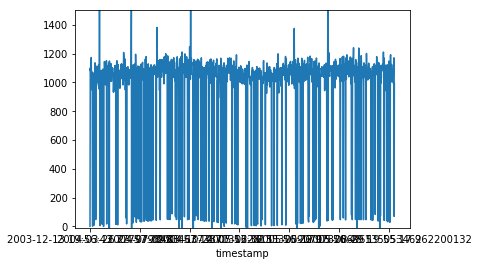

In [4]:
# Plot every 75th observation
(rms.iloc[::75, :])['rpm'].plot(ylim=(-10, 1500))

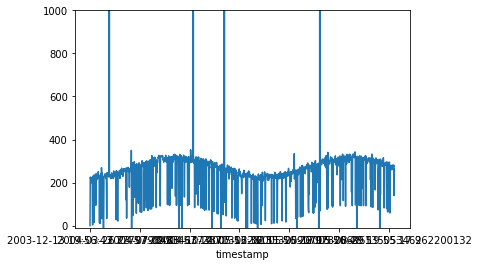

In [5]:
(rms.iloc[::75, :])['motor_voltage'].plot(ylim=(-10, 1000))

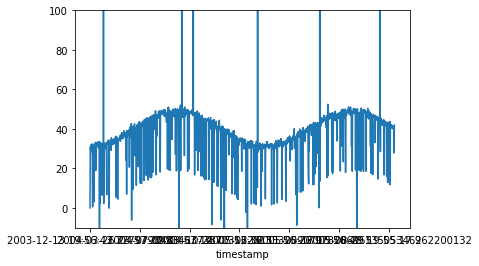

In [6]:
(rms.iloc[::75, :])['motor_current'].plot(ylim=(-10, 100))

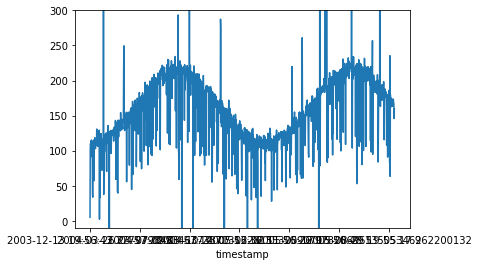

In [7]:
(rms.iloc[::75, :])['motor_temp'].plot(ylim=(-10, 300))

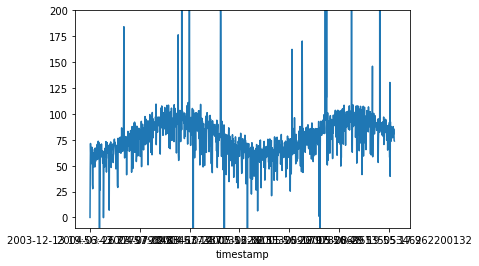

In [8]:
(rms.iloc[::75, :])['inlet_temp'].plot(ylim=(-10, 200))

It appears there are quite a few outlier values, both large and small. The goal is to determine which correspond to communication errors and which are true observations of the state of the machine.

In [9]:
# Do outlier values appear jointly in all variables?
rpm_outliers_h = rms[(rms['rpm'] > 1400)]
print(rpm_outliers_h.shape)

rpm_outliers_l = rms[(rms['rpm'] < 0)]
print(rpm_outliers_l.shape)

(604, 5)
(1247, 5)


In [10]:
# For these observations, it appears all of these values are far outside of the "normal" range,
# meaning they are very likely communication errors
print(rpm_outliers_h.describe())
rpm_outliers_h.head(20)

                rpm  motor_voltage  motor_current    motor_temp    inlet_temp
count  6.040000e+02   6.040000e+02   6.040000e+02  6.040000e+02  6.040000e+02
mean   1.353134e+42   1.495049e+59  -2.107363e+58 -5.215121e+43 -8.652994e+40
std    3.247083e+43   3.674294e+60   5.179141e+59  1.302346e+45  2.115066e+42
min    1.413741e+03  -1.864825e+39  -1.272847e+61 -3.200227e+46 -5.198041e+43
25%    1.599980e+03  -5.018738e+00  -1.193046e+00 -7.591983e+00 -4.935945e-01
50%    4.552622e+04   3.143664e+02   4.381674e+01  1.483777e+02  7.622931e+01
75%    5.518486e+10   3.717684e+02   5.362284e+01  2.275505e+02  1.927244e+02
max    7.978110e+44   9.030096e+61   2.010881e+47  4.980781e+44  1.922968e+39


,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
timestamp,,,,,
2003-12-16 20:47:04.596850546,1.787387e+09,-7.318680e+03,1.705612e+06,4.640380e-01,-1.527750e+09
2003-12-17 19:06:03.676609549,1.404636e+07,-3.221578e+05,4.019652e+02,3.053727e+02,4.060894e+00
2003-12-20 07:46:01.908915832,2.605971e+12,8.863318e+10,-2.273023e+07,6.207863e+04,6.895560e-01
2003-12-20 08:04:23.185882404,2.701374e+25,5.887953e+30,4.683131e+00,2.487060e+10,-7.642170e+03
2003-12-20 22:54:45.437103131,6.094533e+10,-6.260991e+06,3.965442e+06,9.339692e+15,7.784456e+07
2003-12-22 07:16:30.780195942,1.097515e+09,-6.194522e+01,-6.934049e-01,2.992868e+01,-4.156038e-01
2003-12-22 16:56:35.921028470,8.180259e+14,1.006126e+12,1.474772e+16,-3.345856e+07,2.994089e+05
2003-12-22 23:25:04.504183808,1.904850e+06,6.745761e+01,1.822461e+00,6.195056e+01,-4.746086e+06
2003-12-23 21:36:04.315802989,3.756733e+04,2.012820e+13,-9.010020e+03,-8.439913e+21,2.222386e+13


In [11]:
rpm_outliers_l.describe()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,1.247000e+03,1.247000e+03,1.247000e+03,1.247000e+03,1.247000e+03
mean,-5.965632e+48,1.203042e+62,2.252498e+50,-2.509593e+54,-8.184965e+44
std,2.106602e+50,4.248290e+63,6.845491e+51,8.950895e+55,2.889942e+46
min,-7.439020e+51,-1.619693e+51,-2.467017e+44,-3.160641e+57,-1.020522e+48
25%,-1.479278e+05,-6.097191e+01,-1.217458e+01,-4.428013e-01,-1.286405e-01
50%,-2.865138e+01,-3.351805e+01,-6.755424e+00,4.974679e+01,4.896254e+01
75%,-1.376368e+01,-7.813825e-02,8.421847e-02,8.382735e+01,8.309580e+01
max,-8.738786e-05,1.500194e+65,2.379193e+53,3.117856e+55,1.710299e+40


While the above check on outliers is helpful, there's far too much data to be examined manually. Unsupervised clustering methods are useful in determining meaningful clustering in large datasets, and given that we know that there at least two distinct groups ("normal" observations and comm errors) I decided to implement one of the clustering methods on the first training dataset.

I decided to use DBSCAN over other methods such as k-means or spectral clustering for several reasons:

- DBSCAN does not assume any distribution of values for the features (for example, that they follow a Gaussian distribution)
- Works well for multi-dimensional data
- Easy to implement using sklearn

The drawbacks of DBSCAN are:

- Requires scaling of the feature space
- Needs to be re-calibrated each time a new batch of data is analyzed

In [12]:
# Run DBSCAN to cluster data and hopefully identify outliers and comm errors
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

# Scale data using RobustScaler, since outlier values are so large
rms_scaled = RobustScaler().fit_transform(rms.head(10000))

db = DBSCAN(eps=0.8, min_samples=10, n_jobs=-1).fit(rms_scaled)
labels = db.labels_

# Print clusters and number of values assigned to each
print(np.unique(labels, return_counts=True))

# A measure of how well the clustering fits the data (1 is optimal)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(rms_scaled, labels))

# Based on examining the output, I separated the data into three clusters
outliers = np.where(labels == -1)
low_vals = np.where(labels == 0)
normal_vals = np.where(labels == 1)

low_df = rms.iloc[low_vals]
normal_df = rms.iloc[normal_vals]

print(rms.iloc[outliers].describe())
print(low_df.describe())
normal_df.describe()

(array([-1,  0,  1]), array([ 277, 1101, 8622]))
Silhouette Coefficient: 0.842
                rpm  motor_voltage  motor_current    motor_temp    inlet_temp
count  2.770000e+02   2.770000e+02   2.770000e+02  2.770000e+02  2.770000e+02
mean   3.425813e+36   1.492306e+42   4.140826e+43 -2.198757e+72  6.942122e+36
std    5.701689e+37   2.483704e+43   7.042033e+44  3.659461e+73  1.155400e+38
min   -1.157690e+29  -1.864825e+39  -2.467017e+44 -6.090557e+74 -5.217900e+32
25%    2.154233e+01   6.475331e-02  -3.812201e-01  2.198219e+00  3.855364e-01
50%    1.004824e+03   1.592494e+02   1.831921e+01  5.442242e+01  3.576155e+01
75%    1.097112e+03   1.899226e+02   2.477443e+01  8.042011e+01  4.914364e+01
max    9.489501e+38   4.133707e+44   1.171679e+46  1.127631e+35  1.922968e+39
               rpm  motor_voltage  motor_current   motor_temp   inlet_temp
count  1101.000000    1101.000000    1101.000000  1101.000000  1101.000000
mean     13.439529      26.869145       5.381311    54.339697    41.4

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000
mean,1057.757888,235.251676,33.071870,119.577163,64.677325
std,49.830497,13.710443,2.150160,12.890888,8.151187
min,869.994066,179.954772,21.784344,58.204522,26.809372
25%,1024.158176,226.012996,31.569179,111.314948,59.679368
50%,1057.334087,235.124066,32.961083,119.311733,64.903167
75%,1092.177723,244.421445,34.552184,128.078926,70.117644
max,1240.827672,285.006869,39.436461,157.782162,89.789280


The results are demonstrative: there are three distinct clusters of observations within the data. The first and largest group (86% of total) are "normal" observations, displayed directly above. The second group (about 11%) contains curiosly low values for each variable; while each widget appears to be running, the motor is turning much more slowly and drawing less power. The remaining 2-3% are outlier values, which are absurdly large (across all features) and can be removed.

(9723, 5)


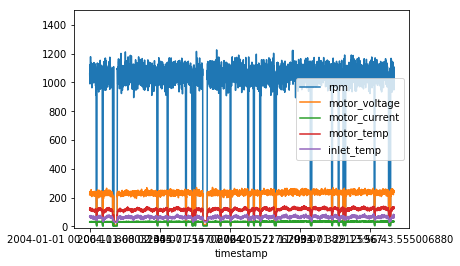

In [13]:
# Create dataframe removing outliers
rms_no_outliers = normal_df.append(low_df)
print(rms_no_outliers.shape)

# Sort by index (datetime) and plot
rms_no = rms_no_outliers.sort_index()
rms_no.loc["2004-01-01":"2004-02-01"].plot(ylim=(-10, 1500))

Plot normal range values and low values separately

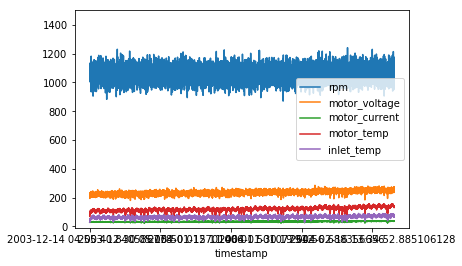

In [14]:
# Plot normal range data only
normal_df.plot(ylim=(-10, 1500))
plt.show()

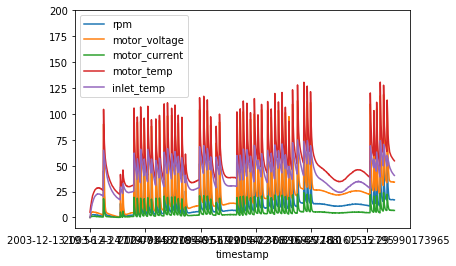

In [15]:
# Examine small values only
low_df.plot(ylim=(-10, 200))
plt.show()

How often do these "low power" phases occur, and for how long do they last?

In [17]:
# 70 instances of low values for widget 1 
low_df['timestamp'] = pd.to_datetime(low_df.index)
low_df.head()
low_df['date'] = low_df['timestamp'].dt.date
print(len(low_df['date'].value_counts()))
low_df['date'].value_counts()[0:10]

44


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


2004-02-09    140
2003-12-19     95
2004-01-03     64
2004-01-12     63
2004-02-10     51
2004-02-08     48
2004-02-19     40
2004-01-11     32
2004-01-26     29
2003-12-26     29
Name: date, dtype: int64

In [19]:
# Do alarms line up with this data? Check for longest "low power" period
alarms.loc['2004-02-08':'2004-02-10']   # Nothing there

,message
timestamp,


Look at how quickly widget switches from normal operation to low power mode

In [20]:
import datetime

rms_no['timestamp'] = pd.to_datetime(rms_no.index)
rms_no['date'] = rms_no['timestamp'].dt.date
rms_no['date2'] = rms_no['date'].apply(lambda x: datetime.datetime(*(x.timetuple()[:6])))
low_activity = rms_no[(rms_no['date2'] >= '2004-02-08') & (rms_no['date2'] <= '2004-02-10')]

In [21]:
# Look at decreases in all variables: how quickly did this decrease occur?
# Seems to be immediate
low_activity.iloc[90:115]

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,timestamp,date,date2
timestamp,,,,,,,,
2004-02-08 15:15:43.483288112,1154.448525,222.811633,34.537851,129.914792,71.128285,2004-02-08 15:15:43.483288112,2004-02-08,2004-02-08
2004-02-08 15:25:46.023781569,1048.379760,250.343096,35.482410,124.597596,68.365777,2004-02-08 15:25:46.023781569,2004-02-08,2004-02-08
2004-02-08 15:35:03.261246857,1059.335184,230.918870,33.840344,128.733203,64.616825,2004-02-08 15:35:03.261246857,2004-02-08,2004-02-08
2004-02-08 15:44:01.005601665,1177.519288,258.936412,35.061017,134.972846,58.860737,2004-02-08 15:44:01.005601665,2004-02-08,2004-02-08
2004-02-08 15:56:01.980839024,1087.692159,266.470240,32.548072,123.136252,66.165614,2004-02-08 15:56:01.980839024,2004-02-08,2004-02-08
2004-02-08 16:06:23.112401831,55.663803,111.101754,22.205385,121.462032,69.238990,2004-02-08 16:06:23.112401831,2004-02-08,2004-02-08
2004-02-08 16:16:35.169946697,44.042990,88.179731,17.648356,105.194253,67.254471,2004-02-08 16:16:35.169946697,2004-02-08,2004-02-08
2004-02-08 16:26:40.087344036,34.036920,68.106435,13.523407,92.695583,64.884247,2004-02-08 16:26:40.087344036,2004-02-08,2004-02-08
2004-02-08 16:35:16.161512795,27.430548,55.151025,10.867273,85.117863,62.676591,2004-02-08 16:35:16.161512795,2004-02-08,2004-02-08


Now that outliers have been filtered out, it would be helpful to understand whether each observation is correlated with the ones before it or whether they are independent. An autocorrelation plot is an easy way to see the strength of the relationship between lagged and present observations:

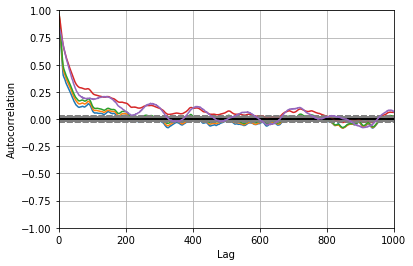

In [22]:
from pandas.plotting import autocorrelation_plot

# As we'd expect, the measurements are not independent
autocorrelation_plot(rms_no['rpm'])
autocorrelation_plot(rms_no['motor_voltage'])
autocorrelation_plot(rms_no['motor_current'])
autocorrelation_plot(rms_no['motor_temp'])
autocorrelation_plot(rms_no['inlet_temp'])
plt.xlim([0, 1000])
plt.show()

The autocorrelation for all variables drops off for the most part after 750 periods.

### Modeling/machine learning

The autocorrelation plot above suggests that if there is a signal that can predict machine failure, it would be found in the 750 observations preceding the time period at which we'd like to predict. Therefore, building a classification model requires:

- Extracting the last 750 observations from each training dataset (positive examples for classifier, since each machine failed at the end of each corresponding dataset)

- Extracting a comparable number of negative observations, ideally from the beginning of each dataset (as far away from failure time as possible). These will be the negative examples fed into the classifier.

The question that remains is how to filter out the outliers effectively. As mentioned before, DBSCAN is sensitive to different data batches, and therefore using it to detect outliers would mean the parameters would have to be manually adjusted and the clusters verified for twenty different datasets. Instead, I decided to assume the DBSCAN output (on the first 10,000 observations of rms0000) was a representative sample of the data, and create a rule-based filtering paradigm to remove outliers.



(9866, 5)


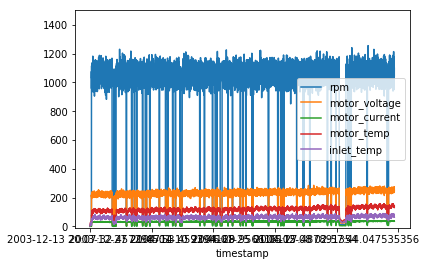

In [23]:
# Function to filter out outlier observations, based on "good observation" threshold from DBSCAN clustering
def filter_outliers(df):
    df = df[(df['rpm'] <= 1400) & (df['rpm'] > 0)]
    df = df[(df['motor_voltage'] <= 300) & (df['motor_voltage'] > 0)]
    df = df[(df['motor_current'] <= 60) & (df['motor_current'] > 0)]
    df = df[(df['motor_temp'] <= 180) & (df['motor_temp'] > 0)]
    df = df[(df['inlet_temp'] <= 100) & (df['inlet_temp'] > 0)]
    
    return df

# Test case: using DB scan and original rms
test_df = filter_outliers(rms.head(10000))
print(test_df.shape)
test_df.plot(ylim=(-10, 1500))

I next created the positive examples for my training set by taking the last 750 (based on the autocorrelation plot) non-outlier observations in each dataset. The "target" variable can be thought of as an indicator of the event "the machine will fail in the next 750 periods or less".

In [24]:
import glob

# List of rms training datasets
ds_list = glob.glob('data/train/unit00**_rms.csv')

train_pos = pd.DataFrame([])

for ds in ds_list:
    data = load_rms(ds)
    pos_ex = (filter_outliers(data).tail(750))
    train_pos = train_pos.append(pos_ex)

In [27]:
print(train_pos.shape)

# Indicator variable which will be used for classifier: does a failure happen in the next 
# 750 time periods or less?
train_pos['target'] = 1

(15000, 6)


To construct the negative examples, I took the first 1500 observations from each dataset except for rms0013, which had less than 1500 observations. I only took the first 500 observations from this dataset and then filtered to remove outliers to make sure to avoid overlapping with the positive examples. I chose to take 1500 from each dataset because more data helps the classifier learn, but when the classes get too imbalanced the classifier starts to have problems. I thought a 2 to 1 ratio would avoid this problem but give ample data for the classifer to train on.

In [28]:
# Take first 1500 filtered observations from each dataset except for unit 13 (just take 
# however many remain from first 500 after filtering out outliers)
train_neg = pd.DataFrame([])

for ds in ds_list[0:13]:
    data = load_rms(ds)
    neg_ex = (filter_outliers(data).head(1500))
    train_neg = train_neg.append(neg_ex)
    
# This time, take head and then filter, to be extra careful about overlapping obs.
rms13 = load_rms('data/train/unit0013_rms.csv') 
train_neg = train_neg.append(filter_outliers(rms13.head(500)))

for ds in ds_list[14:]:
    data = load_rms(ds)
    neg_ex = (filter_outliers(data).head(1500))
    train_neg = train_neg.append(neg_ex)
    
print(train_neg.shape)

train_neg['target'] = 0

(28989, 5)


In [29]:
from sklearn.utils import shuffle
import random

# Put pos. and neg. examples together
train_final = train_pos.append(train_neg).reset_index()
train_final.drop(columns='timestamp', inplace=True)
print(train_final.shape)

# Random shuffle of training data
random.seed(1993)
train_final = train_final.sample(frac=1, random_state=1993)
train_final.head(10)

(43989, 6)


,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,target
7275,1030.943981,244.802587,37.669032,122.467943,62.573625,1
4790,1100.885832,234.333422,32.043097,94.287310,44.421874,1
23268,1080.650578,234.570400,31.200201,106.554470,50.271665,0
29859,32.314395,64.655667,13.134639,78.973182,52.713075,0
42771,1042.951206,238.288165,31.077095,119.222902,73.908708,0
7284,1033.851665,236.407026,37.184741,135.085583,68.438047,1
16720,1102.799636,222.781802,30.089590,104.056580,63.453260,0
27100,1090.303551,226.373533,29.636343,102.967485,50.299483,0
30371,1.473025,3.077438,0.656034,34.076342,28.560613,0
2344,1144.315806,294.340188,43.605369,179.683252,88.624731,1


In [30]:
# Random forest classifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = train_final.drop(columns='target').as_matrix()
y = train_final['target'].values

rf_clf = RandomForestClassifier()
rf_clf.fit(X, y)

# 10-fold CV to evaluate model accuracy
scores = cross_val_score(rf_clf, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.87178904  0.8686065   0.86928847  0.86656058  0.87769948  0.87383496
  0.86519664  0.87542623  0.86815185  0.87107776]
Accuracy: 0.87 (+/- 0.01)


In [31]:
# Gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X, y)

# 10-fold CV 
scores = cross_val_score(gb_clf, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.87906342  0.87769948  0.87497158  0.87269834  0.87656286  0.88270061
  0.86701523  0.87679018  0.87747215  0.87471578]
Accuracy: 0.88 (+/- 0.01)


In [32]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X, y)

# 10-fold CV 
scores = cross_val_score(lr_clf, X, y, cv=10)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[ 0.84291885  0.84678336  0.84655604  0.84178222  0.84837463  0.8508752
  0.84473744  0.85246647  0.84678336  0.83969986]
Accuracy: 0.846 (+/- 0.008)


The gradient boosting classifer appears to perform the best in terms of cross-validation accuracy, so I'll focus upon on that moving forward.

In [33]:
# Confusion matrix for GB classifier
from sklearn.metrics import confusion_matrix
confusion_matrix(y, gb_clf.predict(X))   # Many more false negatives in comparison to # of false positives

array([[28149,   840],
       [ 4487, 10513]])

In [34]:
# Read in test data
ds_list_test = glob.glob('data/test/unit*_rms.csv')

# First see size of new datasets
for ds in ds_list_test:
    data = load_rms(ds)
    print(data.shape)

(4465, 5)
(4465, 5)
(4465, 5)
(1214, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)
(4465, 5)


Determining which machine is most likely to fail is not straightforward, since instead of a new set of instances to classify, we would just like our model to output a probability that the machine will fail. I decided to calculate the number of positive predictions output by the classifer on the last 750 observations of each dataset (after being filtered for outliers) and used this to rank likelihood of failure. 

In [35]:
pred_sums = []

for ds in ds_list_test:
    data = load_rms(ds)
    filt_df = filter_outliers(data).tail(750)
    pred_vals = gb_clf.predict(filt_df.as_matrix())
    pred_sums.append(sum(pred_vals))
    
sums_with_idx = list(zip([i for i in range(len(ds_list_test))], pred_sums))
list(reversed(sorted(sums_with_idx, key=lambda x: x[1])))

[(6, 738),
 (10, 737),
 (2, 737),
 (17, 736),
 (1, 731),
 (9, 730),
 (8, 730),
 (28, 729),
 (29, 728),
 (4, 726),
 (0, 726),
 (24, 723),
 (22, 723),
 (16, 721),
 (15, 721),
 (18, 719),
 (26, 718),
 (21, 716),
 (20, 708),
 (11, 702),
 (5, 702),
 (23, 701),
 (7, 698),
 (13, 696),
 (27, 687),
 (25, 681),
 (14, 667),
 (19, 664),
 (12, 573),
 (3, 526)]

According to my model, machines 6, 10, 2, 17, and 1 are most likely to fail respectively. The major drawback of ranking them in this fashion is that it is impossible to place a precise degree of uncertainty for each prediction (it would be unwise to assume that 738/750 positive classifications mean that there is a 98.4% chance that the machine will fail immediately). However, I do believe that this ranking system has a solid mathematical foundation and provides a useful way to rank the likelihood of failure for the 30 test machines. 

If I had had more time to work on this project, I would have 

- Explored different classifiers such as neural networks
- Come up with a more elegant way to automatically remove outliers from new data batches
- Done more exploratory analysis on the alarm data and incorporated information on warning and error times in my predictive model
